Data loaded successfully.


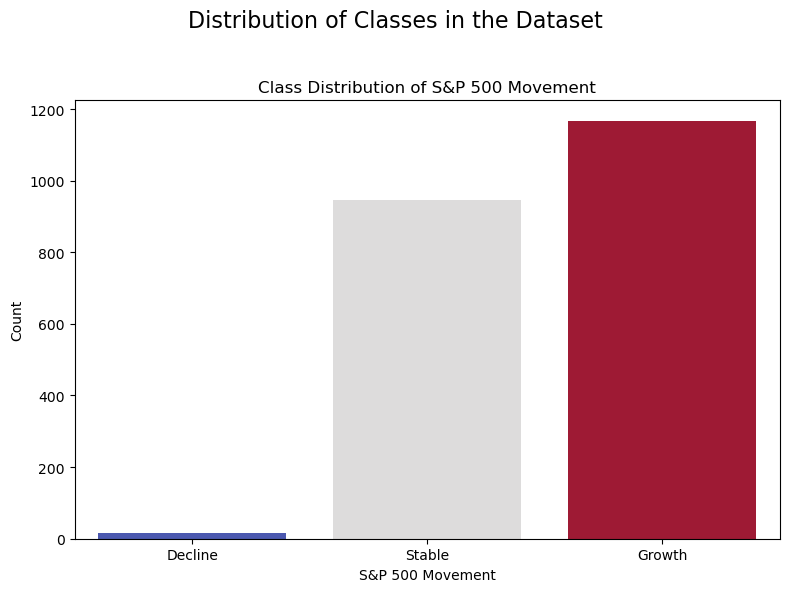

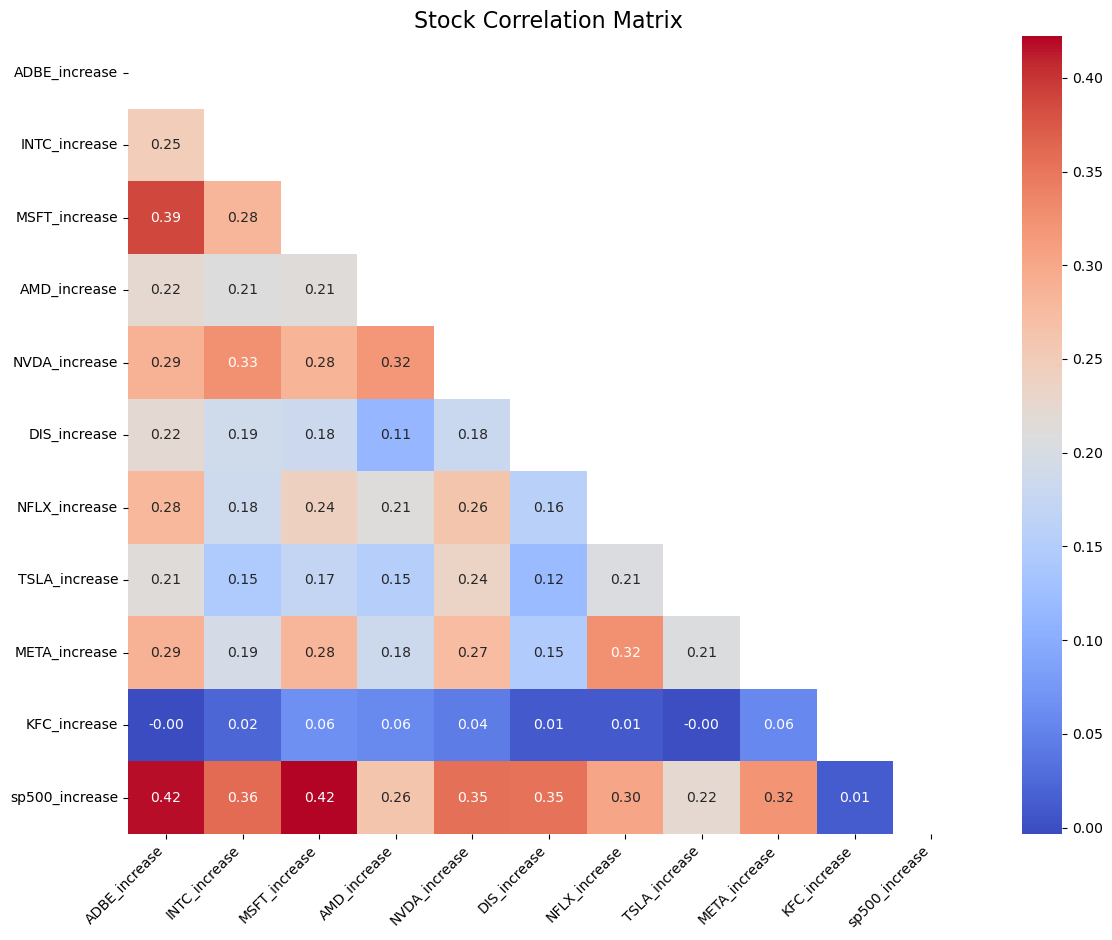

RandomForest model trained successfully.
GradientBoosting model trained successfully.
LogisticRegression model trained successfully.

RandomForest Model Evaluation:
              precision    recall  f1-score   support

     Decline       0.00      0.00      0.00         3
      Stable       0.76      0.75      0.76       190
      Growth       0.80      0.80      0.80       233

    accuracy                           0.77       426
   macro avg       0.52      0.52      0.52       426
weighted avg       0.78      0.77      0.78       426


GradientBoosting Model Evaluation:
              precision    recall  f1-score   support

     Decline       0.00      0.00      0.00         3
      Stable       0.77      0.74      0.75       190
      Growth       0.79      0.82      0.81       233

    accuracy                           0.78       426
   macro avg       0.52      0.52      0.52       426
weighted avg       0.78      0.78      0.78       426


LogisticRegression Model Evaluation:

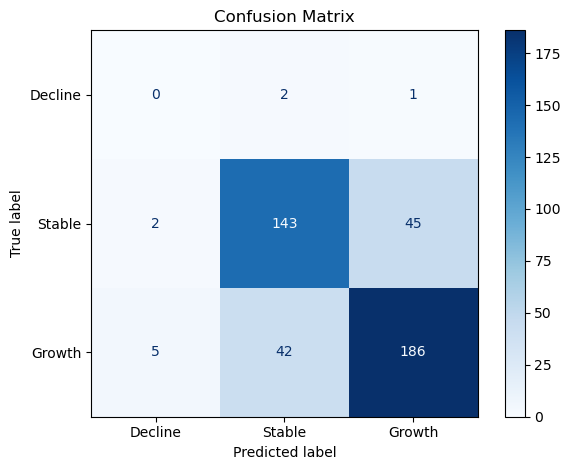

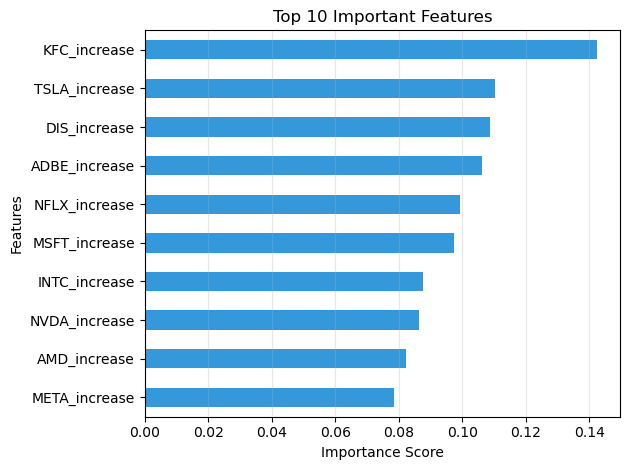

Model 'RandomForest' saved to 'sp500_model.joblib'.

=== S&P 500 Movement Prediction ===
Enter 10 comma-separated values for features:
Feature order: ADBE_increase, INTC_increase, MSFT_increase, AMD_increase, NVDA_increase, DIS_increase, NFLX_increase, TSLA_increase, META_increase, KFC_increase


Input (e.g., 0.5,-0.3,0.7,-0.1,0.4,0.2,-0.6,0.8,-0.2,0.1):  0.5,-0.3,0.7,-0.1,0.4,0.2,-0.6,0.8,-0.2,0.1


Predicted Market Movement: Growth


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import joblib


class DataHandler:
    def __init__(self, filepath):
        self.filepath = filepath
        self.data = None
        self.features = [
            'ADBE_increase', 'INTC_increase', 'MSFT_increase',
            'AMD_increase', 'NVDA_increase', 'DIS_increase',
            'NFLX_increase', 'TSLA_increase', 'META_increase',
            'KFC_increase'
        ]

    def load_data(self):
        self.data = pd.read_csv(self.filepath)
        self.data['Date'] = pd.to_datetime(self.data['Date'])
        self.data.dropna(inplace=True)
        print("Data loaded successfully.")

    def get_features_and_target(self):
        X = self.data[self.features]
        y = self.data['sp500_increase']
        return X, y

    def plot_class_distribution(self):
        plt.figure(figsize=(8, 6))
        sns.countplot(data=self.data, x='sp500_increase', hue='sp500_increase', palette='coolwarm', legend=False)
        plt.title("Class Distribution of S&P 500 Movement")
        plt.xlabel("S&P 500 Movement")
        plt.ylabel("Count")
        plt.xticks(ticks=[0, 1, 2], labels=['Decline', 'Stable', 'Growth'])
        plt.suptitle("Distribution of Classes in the Dataset", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

    def plot_correlation_matrix(self):
        plt.figure(figsize=(12, 10))
        numeric_data = self.data[self.features + ['sp500_increase']]
        correlation_matrix = numeric_data.corr()
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
        sns.heatmap(
            correlation_matrix,
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            cbar=True,
            mask=mask
        )
        plt.title("Stock Correlation Matrix", fontsize=16)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

    def plot_confusion_matrix(self, y_test, y_pred):
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Decline', 'Stable', 'Growth'])
        disp.plot(cmap='Blues', values_format='d')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.show()

    def plot_feature_importance(self, model):
        feature_importance = pd.Series(model.feature_importances_, index=self.features)
        feature_importance.nlargest(10).sort_values().plot(kind='barh', color='#3498db')
        plt.title('Top 10 Important Features')
        plt.xlabel('Importance Score')
        plt.ylabel('Features')
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()


class ModelTrainer:
    def __init__(self):
        self.models = {
            "RandomForest": RandomForestClassifier(class_weight='balanced', n_jobs=-1),
            "GradientBoosting": GradientBoostingClassifier(),
            "LogisticRegression": OneVsRestClassifier(LogisticRegression(max_iter=1000, n_jobs=-1))
        }
        self.scaler = StandardScaler()
        self.feature_names = None

    def train_test_split(self, X, y):
        self.feature_names = X.columns.tolist()
        return train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    def train_models(self, X_train, y_train):
        X_train_scaled = self.scaler.fit_transform(X_train)
        for name, model in self.models.items():
            model.fit(X_train_scaled, y_train)
            print(f"{name} model trained successfully.")

    def evaluate_models(self, X_test, y_test):
        X_test_scaled = self.scaler.transform(X_test)
        for name, model in self.models.items():
            y_pred = model.predict(X_test_scaled)
            print(f"\n{name} Model Evaluation:")
            print(classification_report(y_test, y_pred,
                                        target_names=['Decline', 'Stable', 'Growth'],
                                        zero_division=0))

    def save_model(self, model_name, filename):
        if model_name in self.models:
            joblib.dump((self.models[model_name], self.scaler, self.feature_names), filename)
            print(f"Model '{model_name}' saved to '{filename}'.")
        else:
            print("Invalid model name.")

    def load_model(self, filename):
        model, scaler, feature_names = joblib.load(filename)
        self.feature_names = feature_names
        return model, scaler

    def predict(self, model, scaler, input_data):
        try:
            if len(input_data) != len(self.feature_names):
                raise ValueError(f"Expected {len(self.feature_names)} features, got {len(input_data)}")
            input_df = pd.DataFrame([input_data], columns=self.feature_names)
            input_scaled = scaler.transform(input_df)
            prediction = model.predict(input_scaled)
            return prediction
        except Exception as e:
            print(f"Prediction error: {str(e)}")
            return None


if __name__ == "__main__":
    # Initialize DataHandler with the correct file path
    data_handler = DataHandler("/Users/ihorkorolov/PycharmProjects/machinelearning/data/sp500_stocks.csv")
    data_handler.load_data()

    # Plot the class distribution
    data_handler.plot_class_distribution()

    # Plot the correlation matrix
    data_handler.plot_correlation_matrix()

    # Prepare features and target
    X, y = data_handler.get_features_and_target()

    # Initialize ModelTrainer
    trainer = ModelTrainer()

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = trainer.train_test_split(X, y)

    # Train the models
    trainer.train_models(X_train, y_train)

    # Evaluate the models
    trainer.evaluate_models(X_test, y_test)

    # Choosing RandomForest model as an example for feature importance and confusion matrix
    rf_model = trainer.models["RandomForest"]
    y_pred = rf_model.predict(trainer.scaler.transform(X_test))

    # Plot confusion matrix
    data_handler.plot_confusion_matrix(y_test, y_pred)

    # Plot top 10 important features
    data_handler.plot_feature_importance(rf_model)

    # Save the RandomForest model
    trainer.save_model("RandomForest", "sp500_model.joblib")

    print("\n=== S&P 500 Movement Prediction ===")
    model, scaler = trainer.load_model("sp500_model.joblib")
    print("Enter 10 comma-separated values for features:")
    print("Feature order:", ', '.join(data_handler.features))

    while True:
        try:
            user_input = input("Input (e.g., 0.5,-0.3,0.7,-0.1,0.4,0.2,-0.6,0.8,-0.2,0.1): ")
            input_data = [float(x.strip()) for x in user_input.split(',')]
            if len(input_data) != 10:
                print("Error: Please enter exactly 10 values")
                continue
            prediction = trainer.predict(model, scaler, input_data)
            if prediction is not None:
                movement = {-1: "Decline", 0: "Stable", 1: "Growth"}
                print(f"Predicted Market Movement: {movement[prediction[0]]}")
            break
        except ValueError:
            print("Invalid input. Please enter numbers only.")
        except Exception as e:
            print(f"Unexpected error: {str(e)}")
            break